# Mall Customer Clustering

Clustering is the process of grouping-- assigning a distinct label-- instances/objects together that are more similar to one another than objects not in that assigned group/cluster.  It can be helpful for feature engineering, for pulling patterns and insight out of data, as well as many other applications in machine leraning and analysis.  

Clustering is done without prior knowledge of what group, or how many, might apply to a dataset.  For that reason, we can apply unsupervised learning algorithms to this process.  Different methods apply different weights to the relationships between instances, looking over a wide set of feature spaces to determine which instances go in which group/cluster.  I'll utlize three of Scikit-learn's clustering algorithms on the [Mall Customer Segmentation Dataset](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data):
 - [K-Means Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
 - [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
 - [MeanShift](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)

In [1]:
# Import the libraries we'll be using for data wrangling/analysis and visualization to start
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Assets/Mall_Customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Data Analysis

Each instance is a person who spends money at the mall, and we have data on their `Gender`,  `Age`, `Annual Income`, and `Spending Score`.  Let's see if any data is missing:

In [3]:
data.isnull().sum().sum()

0

No missing data.  Let's take a look at the distribution of the data:

In [4]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


To make it easier to work with, I'm going to rename a few features and also make the `CustomerID` the index.

In [6]:
data.rename(index=str, columns={'Annual Income (k$)': 'Income',
                                'Spending Score (1-100)': 'Score',
                                'CustomerID':'ID'}, inplace=True)
data.set_index('ID', inplace=True)
data.head()

,Gender,Age,Income,Score
ID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


Let's visualize the data too, looking at the `Gender` category as a differentiator and seeing the distribution in each remaining feature:

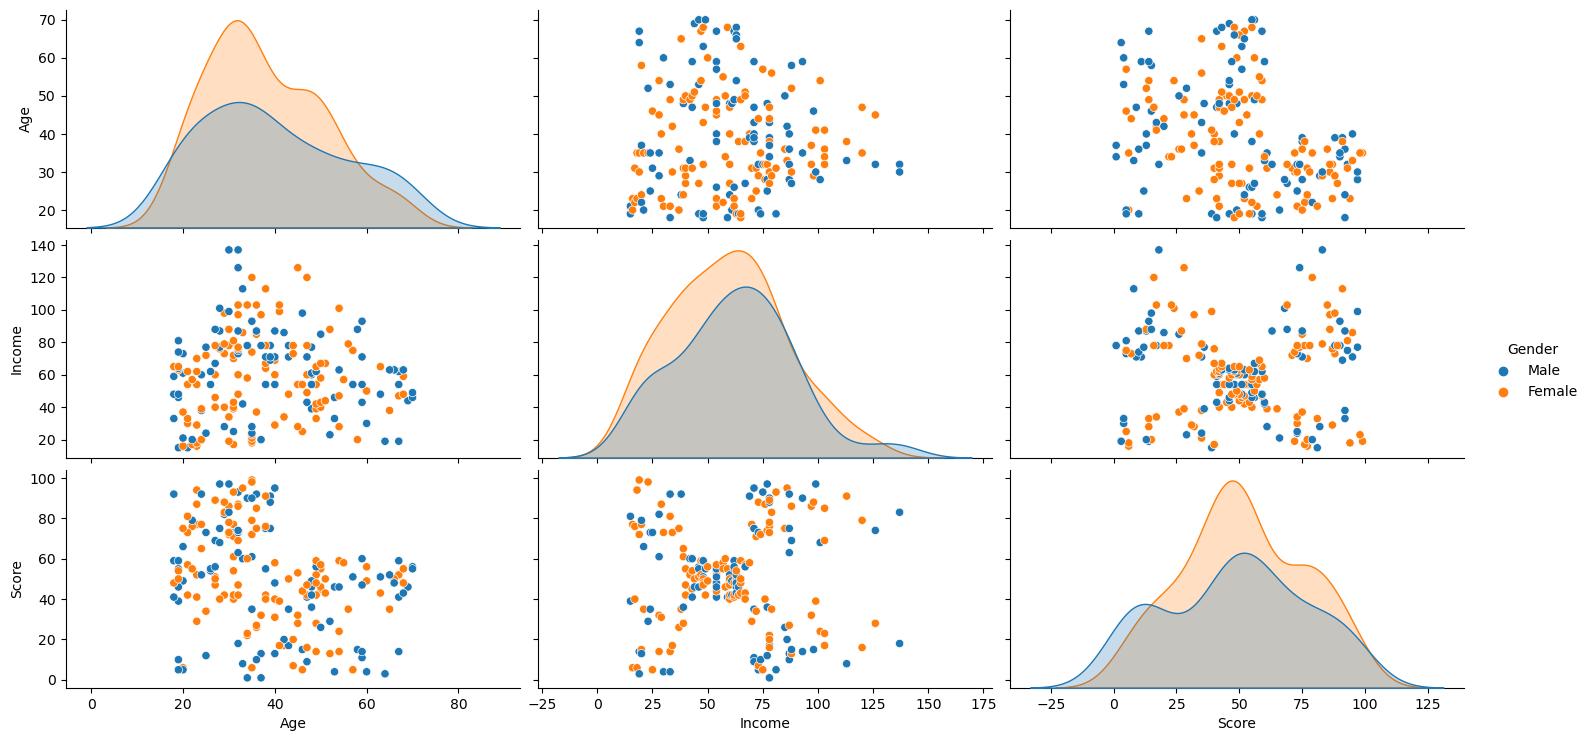

In [7]:
sns.pairplot(data, hue='Gender', aspect=2)
plt.show()

I pick up on two things.  One is that `Gender` is not clearly a differentiator in any other feature, especially related to `Score`.  That is, the blue and the orange dots are not clearly doing any work to differentiate the score as a function of `Age` or of `Income`.  It doesn't add anything, so we'll drop it from our additional analysis.  

In [8]:
X = data.drop(columns=['Gender'])

The second thing I see is that the data is that the score have a bimodal distribution for both genders.  I see that too in the `Age` catgegory, less so in the `Income` category.  That doesn't tell us a whole lot for customer segmentation though.  Let's move on to the actual task of clustering, starting with K-Means.

### K-Means Clustering

"*The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified.*" -- [Scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#k-means)

We are going to pick a number of clusters and then run the algorithm through the data.  It'll move through the feature space and assign instances to one of the n-number of clusters, changing them in order to try to minimze the inertia-- which is similar to Sum of Squared Errors in that it is the sum of squared distances of samples to their closest cluster center-- until the inertia doesn't change much after additional iterations.  For this task, we'll try integers 1 through 10 and plot the inertia.  At some point, there is diminishing returns in the reduction in inertia when adding more clusters, and this is known as an elbow point.  There are often several candidates for elbow points.  Let's take a look:

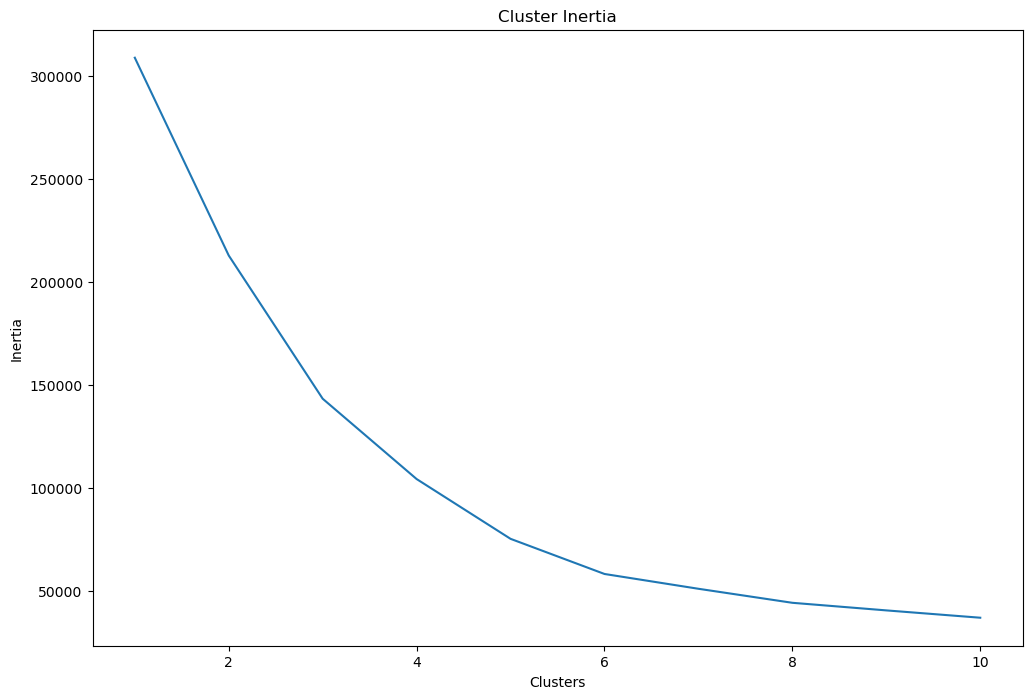

In [9]:
from sklearn.cluster import KMeans

clusters = []
for n in range(1, 11):
    km = KMeans(n_clusters=n, random_state=1).fit(X)
    clusters.append(km.inertia_)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=range(1, 11), y=clusters, ax=ax)
ax.set_title('Cluster Inertia')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')
plt.show();

It isn't exactly clear where the elbow point is.  I see three candidates, at least: `n_cluster` = 3, 5, or 6.  Let's plot the `Scores` for each customer as a function of both `Age` and `Income`, and the number of clusters.

In [10]:
# Define a function to plot clusters based on n and the category under consideration using KMeans Clustering
def cluster_plot(n=3,cat='Income'):
    km_n = KMeans(n_clusters=n, random_state=1).fit(X)
    X['Labels'] = km_n.labels_
    plt.figure(figsize=(8, 3))
    sns.scatterplot(x=X[cat], y=X['Score'], hue=X['Labels'], palette=sns.color_palette('hls', n))
    plt.title(f'KMeans with {n} Clusters - Score vs {cat}')
    plt.show();

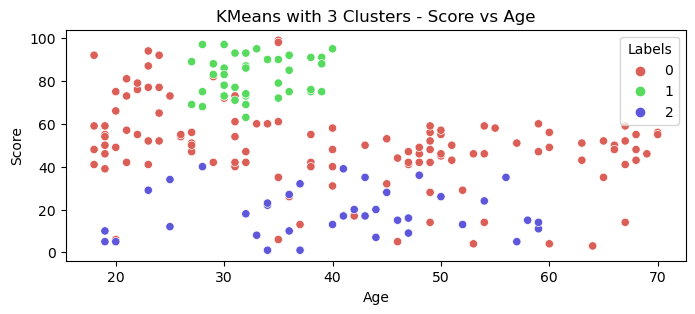

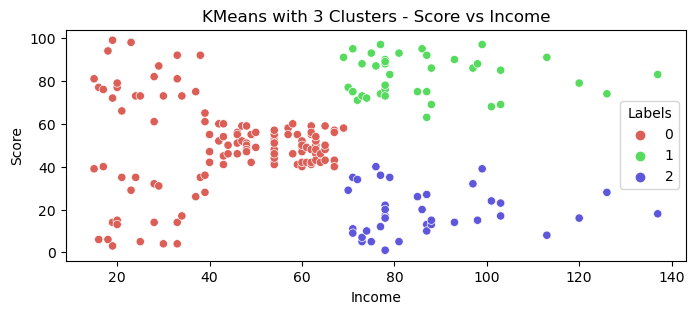

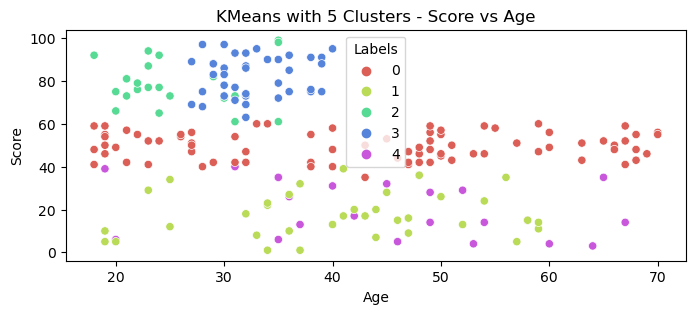

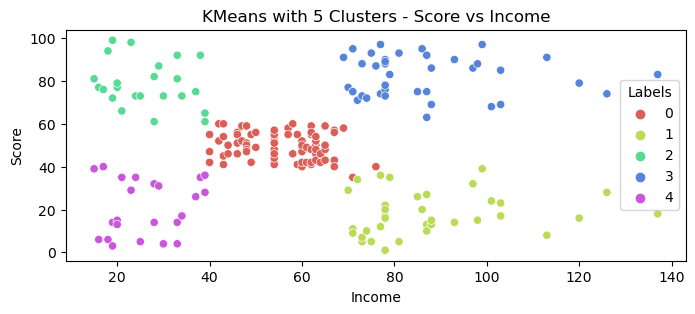

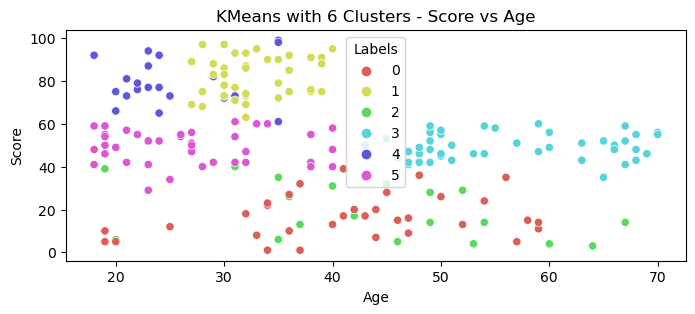

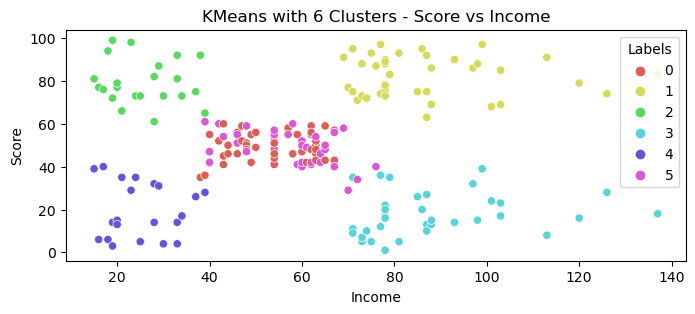

In [11]:
n_list = [3,5,6]
cat_list = ['Age','Income']
for n in n_list:
    for cat in cat_list:
        cluster_plot(n,cat)

We can that there is not very good segmentation when considering `Age` and `Score`.  There is very clear segmentation for the `Score` when it comes to `Income`, however, and `n_clusters=5` seems very appropriate as there are 5 distinct sections of the graph.  Here it is again, by itself:

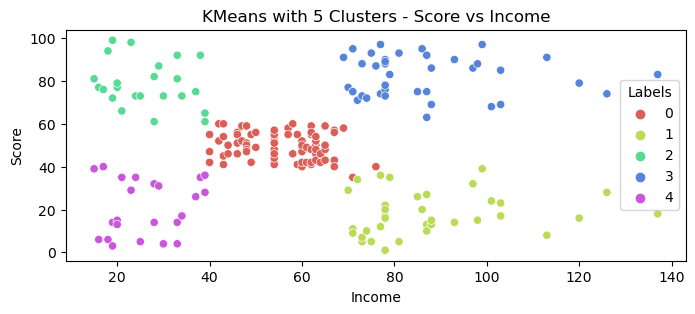

In [12]:
cluster_plot(5,'Income')

These correspond to something like the following descriptions:
 - **Label 0** is "mid" income and "mid" spending
 - **Label 1** is "high" income and "low" spending
 - **Label 2** is "high" income and "high" spending
 - **Label 3** is "low" income and "low" spending
 - **Label 4** is "low" income and "high" spending
 
Swarm plots can be useful in this visualization too.  We'll plot the labels against score and against `Income` and `Age` to check on both here.

In [13]:
# Define a function to plot swarm plots of the segmented data by category (and include Score)
def swarm_plot(cat='Income'):
    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(121)
    sns.swarmplot(x='Labels', y=cat, data=X, ax=ax)
    ax.set_title(f'Labels According to {cat}')
    ax = fig.add_subplot(122)
    sns.swarmplot(x='Labels', y='Score', data=X, ax=ax)
    ax.set_title('Labels According to Scoring History')
    plt.show()

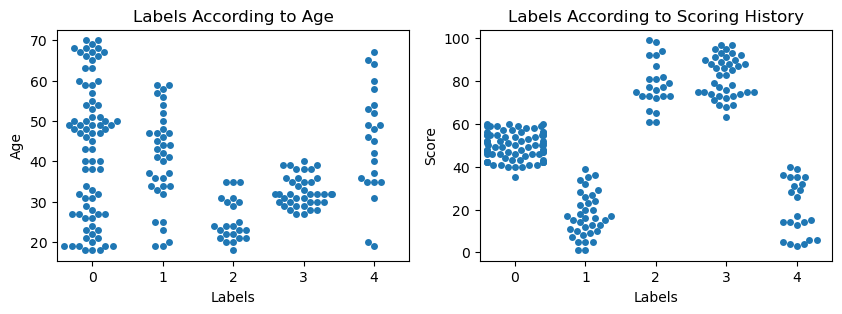

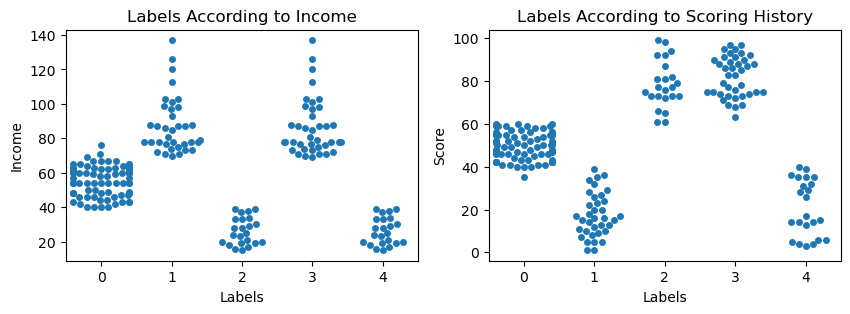

In [14]:
km_5 = KMeans(n_clusters=5, random_state=1).fit(X)
X['Labels'] = km_5.labels_
for cat in cat_list:
    swarm_plot(cat)

For `Age`, we see lots of overlap across the labels, and much less so with `Income`.

### Density Based Clustering (DBSCAN)

"*The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples)*" -- [Scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#dbscan)

If the shape of each cluster is inherently less important than the proximate density, then DBSCAN will be a better option for us.  It isn't clear that this is the case, but we can give it a go.  We'll have to define two variables for the algorithm that determine what it means for a region to be "dense."  "*We define a core sample as being a sample in the dataset such that there exist `min_samples` other samples within a distance of `eps`, which are defined as neighbors of the core sample. This tells us that the core sample is in a dense area of the vector space. Higher `min_samples` or lower `eps` indicate higher density necessary to form a cluster.*" -- [Scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#dbscan)

I'm going to try a few different combinations of these values.  `min_samples` I think should be around or above our number of clusters, so I'll try 6,7, and 8.  I don't know what `eps` should be, so I experimented a bit and somewhere around 10-12 seemed appropriate for getting some decent segmentation.  Let's print the results:

In [15]:
from sklearn.cluster import DBSCAN 
# Define a function to plot clusters based on cat, eps, and min_samples using DBSCAN
def dbscan_plot(epsilon=10, min_samples=5, cat='Income'):
    db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X)
    X['Labels'] = db.labels_
    plt.figure(figsize=(8, 2))
    sns.scatterplot(x=X[cat], y=X['Score'], hue=X['Labels'], palette=sns.color_palette('hls', np.unique(db.labels_).shape[0]))
    plt.title(f'DBSCAN with Epsilon={epsilon}, Minimum Number of samples={min_samples}')
    plt.show()

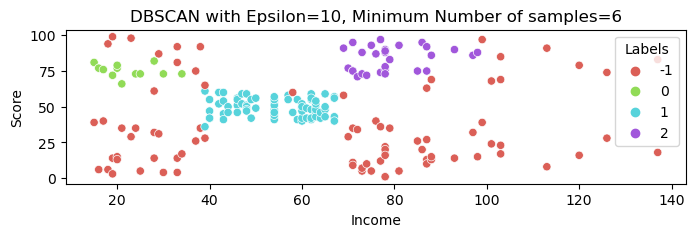

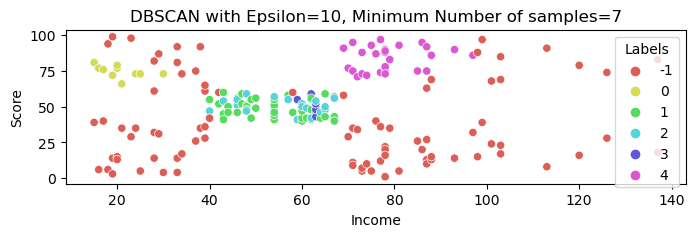

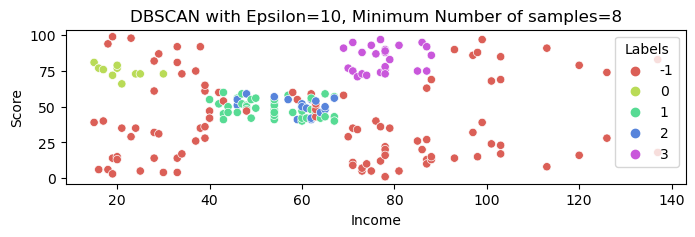

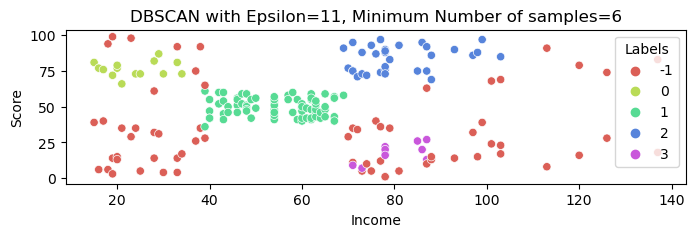

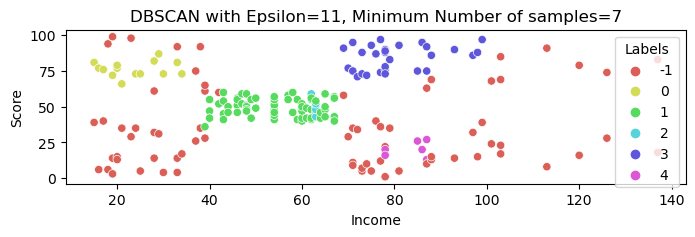

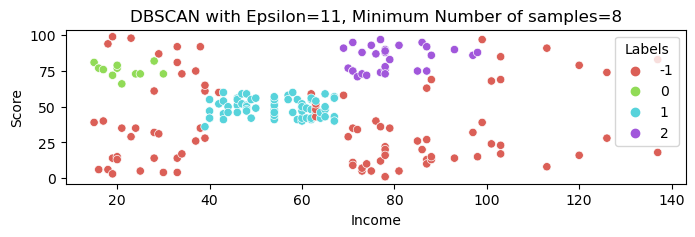

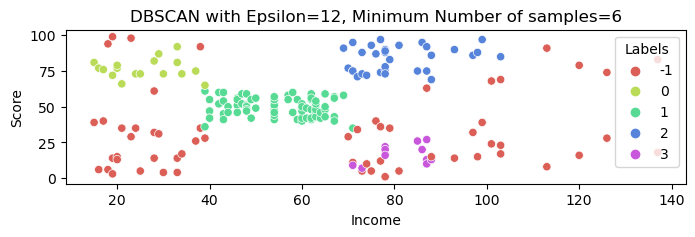

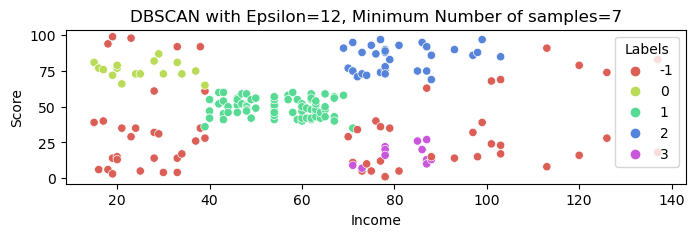

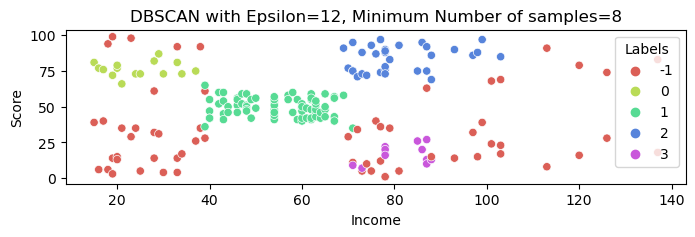

In [16]:
epsilon_list = [10,11,12]
min_samples_list = [6,7,8]
for epsilon in epsilon_list:
    for min_samples in min_samples_list:
        dbscan_plot(epsilon=epsilon, min_samples=min_samples, cat='Income')

With `eps` at 11 and `min_samples` at 6, we get something that looks a decent amount like our K-Means clustering:

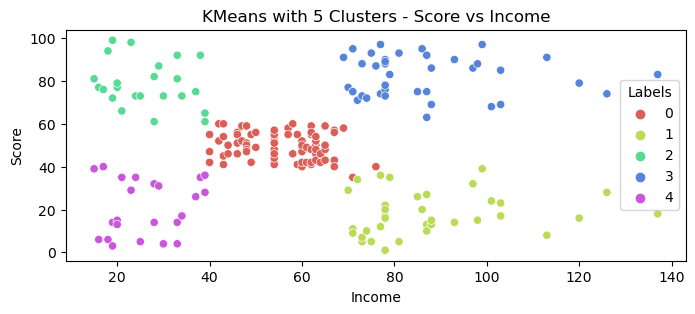

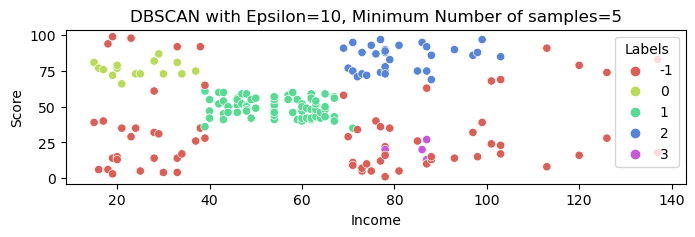

In [17]:
cluster_plot(n=5, cat='Income')
dbscan_plot(epsilon=10, min_samples=5, cat='Income')

DBSCAN doesn't seem to perform as well-- looking at the spray of the red dots for label -1, which indicates outliers from the core areas-- since the density in our data is not that strong.

## Mean Shift Algorithm

"*MeanShift clustering aims to discover blobs in a smooth density of samples. It is a centroid based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.  The position of centroid candidates is iteratively adjusted using a technique called hill climbing, which finds local maxima of the estimated probability density. . . The algorithm automatically sets the number of clusters, instead of relying on a parameter bandwidth, which dictates the size of the region to search through. This parameter can be set manually, but can be estimated using the provided estimate_bandwidth function, which is called if the bandwidth is not set.*"  -- [Scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#mean-shift)

I'll call that bandwidth function to help in this, and we'll let the algorithm do all the work (thanks sklearn!!).  I will also include `Age` back into this, just so we again can see what it looks like compared to when we use `Income` against Score and visualize the clusters.

In [18]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X, quantile=0.1)
ms = MeanShift(bandwidth=bandwidth).fit(X)
X['Labels'] = ms.labels_

In [19]:
# Define a function to plot clusters based on category using Mean Shift
def meanshift_plot(cat='Income'):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=X[cat], y=X['Score'], hue=X['Labels'], palette=sns.color_palette('hls', np.unique(ms.labels_).shape[0]))
    plt.title('MeanShift')
    plt.show()

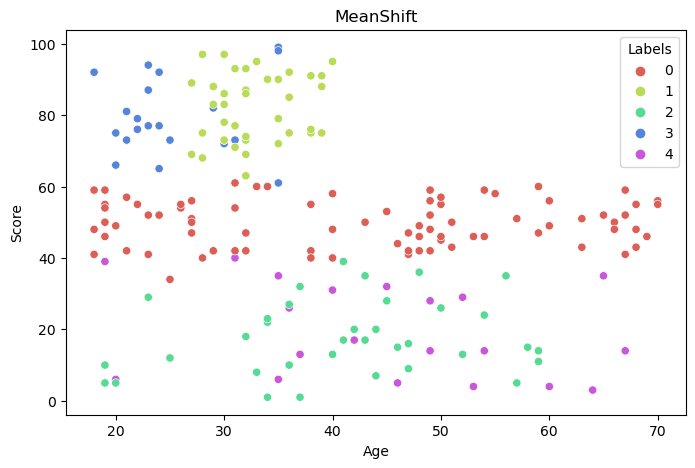

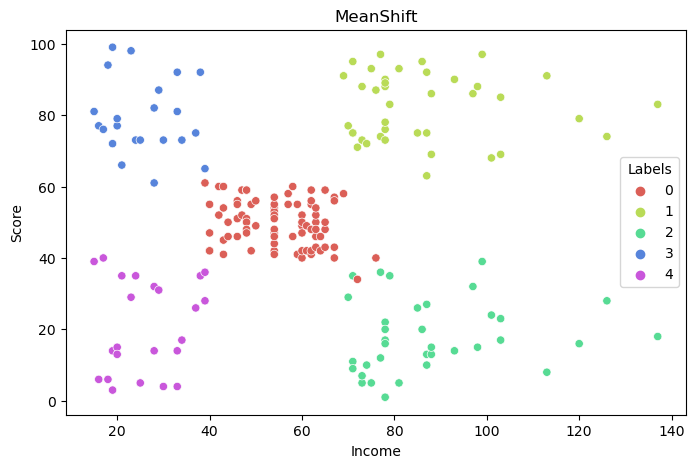

In [20]:
for cat in cat_list:
    meanshift_plot(cat=cat)

As we saw before, `Age` is not a great indicator here, similar to how `Gender` didn't seem to help us in the desire to cluster.  It doesn't mean it isn't a useful feature; it just wasn't as helpful for this exercise.  

### Conclusion

The visualization for `Score` vs. `Income` and the 5 clusters we identified with K-Means match up well between here using Mean Shift.  We can compare the groups by looking at them visually again, and we can also look at how they were segmented with each algorithm.  Here is the K-Means, n=5 plot below to compare to the Mean Shift plot immediately above:

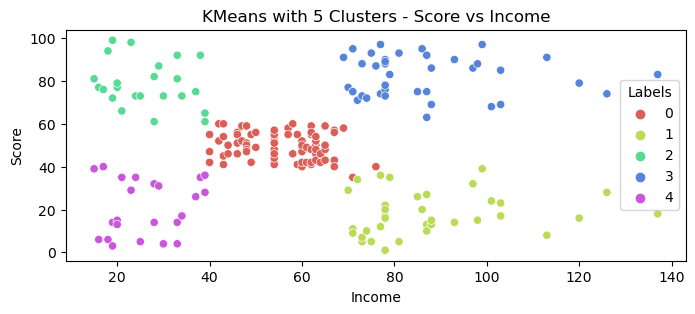

In [21]:
cluster_plot(n=5, cat='Income')

Let's look at the actual labels for each instance:

In [22]:
km_5 = KMeans(n_clusters=5, random_state=1).fit(X)
X.drop(columns='Labels', inplace=True)
X['KM Labels'] = km_5.labels_
X['MS Labels'] = ms.labels_

In [34]:
Labels_df = X[['KM Labels','MS Labels']]
Labels_df.value_counts()

KM Labels  MS Labels
0          0            78
3          1            39
1          2            35
4          4            23
2          3            22
0          2             1
1          0             1
2          0             1
dtype: int64

If there was perfect overlap, we would only see 5 combinations above, where each KM label corresponded to a singl MS Label.  Instead, we see a few additional combinations, but only a single value in each.  So, not perfect overlap, but they are very close-- they only differed by a small fraction of instances in terms of clustering/segmentation.  This helps to reinforce the idea that we have 5 meaningful segmentation categories/segments.